In [1]:
import sys
sys.path.append(".")
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
import matplotlib.pylab as plt
from pathlib import Path
from tensorflow.keras import layers
import datetime
import pandas as pd
from keras.preprocessing import image
import matplotlib.cm as cm
from IPython.display import Image, display




In [2]:
Resnet50_Scratch52_history = np.load("Resnet50_Scratch52_history.npy",allow_pickle=True).item()

In [4]:
# Defining the model

trainable_flag = True
include_top_flag = False
weigths_value = 'imagenet'

if trainable_flag:
    include_top_flag = True
    weigths_value = None
else:
    include_top_flag = False
    weigths_value = 'imagenet'
    
img_height = 224 #B0
img_width = 224 #B0
bs = 16 # batch size
classes_names = ["2_clubs","2_diamonds","2_hearts","2_spades",\
               "3_clubs","3_diamonds","3_hearts","3_spades",\
               "4_clubs","4_diamonds","4_hearts","4_spades",\
               "5_clubs","5_diamonds","5_hearts","5_spades",\
               "6_clubs","6_diamonds","6_hearts","6_spades",\
               "7_clubs","7_diamonds","7_hearts","7_spades",\
               "8_clubs","8_diamonds","8_hearts","8_spades",\
               "9_clubs","9_diamonds","9_hearts","9_spades",\
               "10_clubs","10_diamonds","10_hearts","10_spades",\
               "ace_clubs","ace_diamonds","ace_hearts","ace_spades",\
               "jack_clubs","jack_diamonds","jack_hearts","jack_spades",\
               "king_clubs","king_diamonds","king_hearts","king_spades",\
               "queen_clubs","queen_diamonds","queen_hearts","queen_spades"]

base_model = tf.keras.applications.resnet50.ResNet50(
    weights=weigths_value,
    input_tensor=None,

    pooling=None,
    
    input_shape=(img_height, img_width, 3),
    include_top=include_top_flag,
    classes=len(classes_names) )

inputs = layers.Input(shape=(img_height,img_width,3))
outputs = base_model(inputs)
model = tf.keras.Model( inputs,  outputs)

model.load_weights('Resnet50_Scratch.h5')

In [5]:
testgen = ImageDataGenerator()
test_generator_hard = testgen.flow_from_directory(

    directory = 'dataset_test_hard',
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    shuffle=False,
    #subset='validation',
    interpolation="nearest",
    classes=classes_names) # set as validation data

Found 241 images belonging to 52 classes.


In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), #1e-4
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [7]:
predict = model.predict(test_generator_hard, verbose = 1)
filenames = test_generator_hard.filenames
pred_value = np.max(predict,axis = 1)
pred_idx = (np.argmax(predict,axis = 1)).astype(int).transpose()
pred_class = [classes_names[i] for i in pred_idx]

df = pd.DataFrame(data=pred_idx,columns= ['idx'])
df['pred_class'] = pred_class
df['pred_value'] =  pred_value
df['file_name'] = filenames
df.head()
df.to_csv('dataset_hard_test.csv', index=True)

16/16 [==============================] - 38s 2s/step


In [10]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
last_conv_layer_name  = "conv5_block3_out"
classifier_layer_names = ["avg_pool", "predictions",]

def decode_predictions(pred):
    return (classes_names[np.argmax(pred)], pred[0][np.argmax(pred)]*100)

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
    print("Predicted:", decode_predictions(pred))


Predicted: ('7_diamonds', 99.8982846736908)


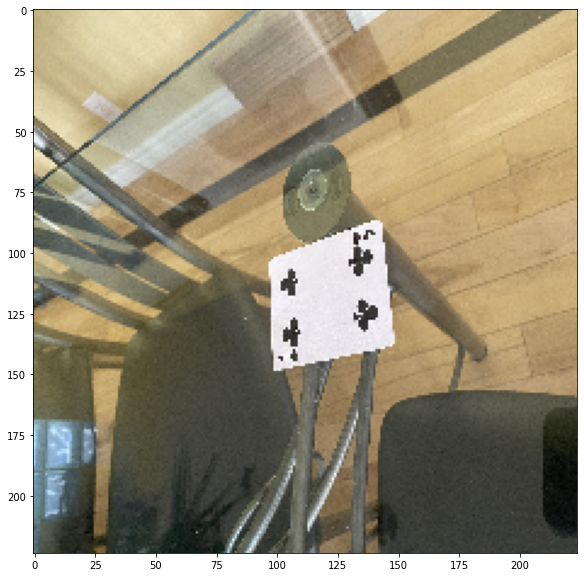

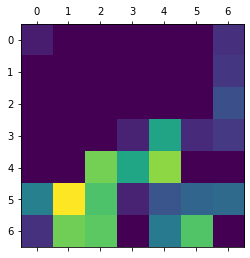

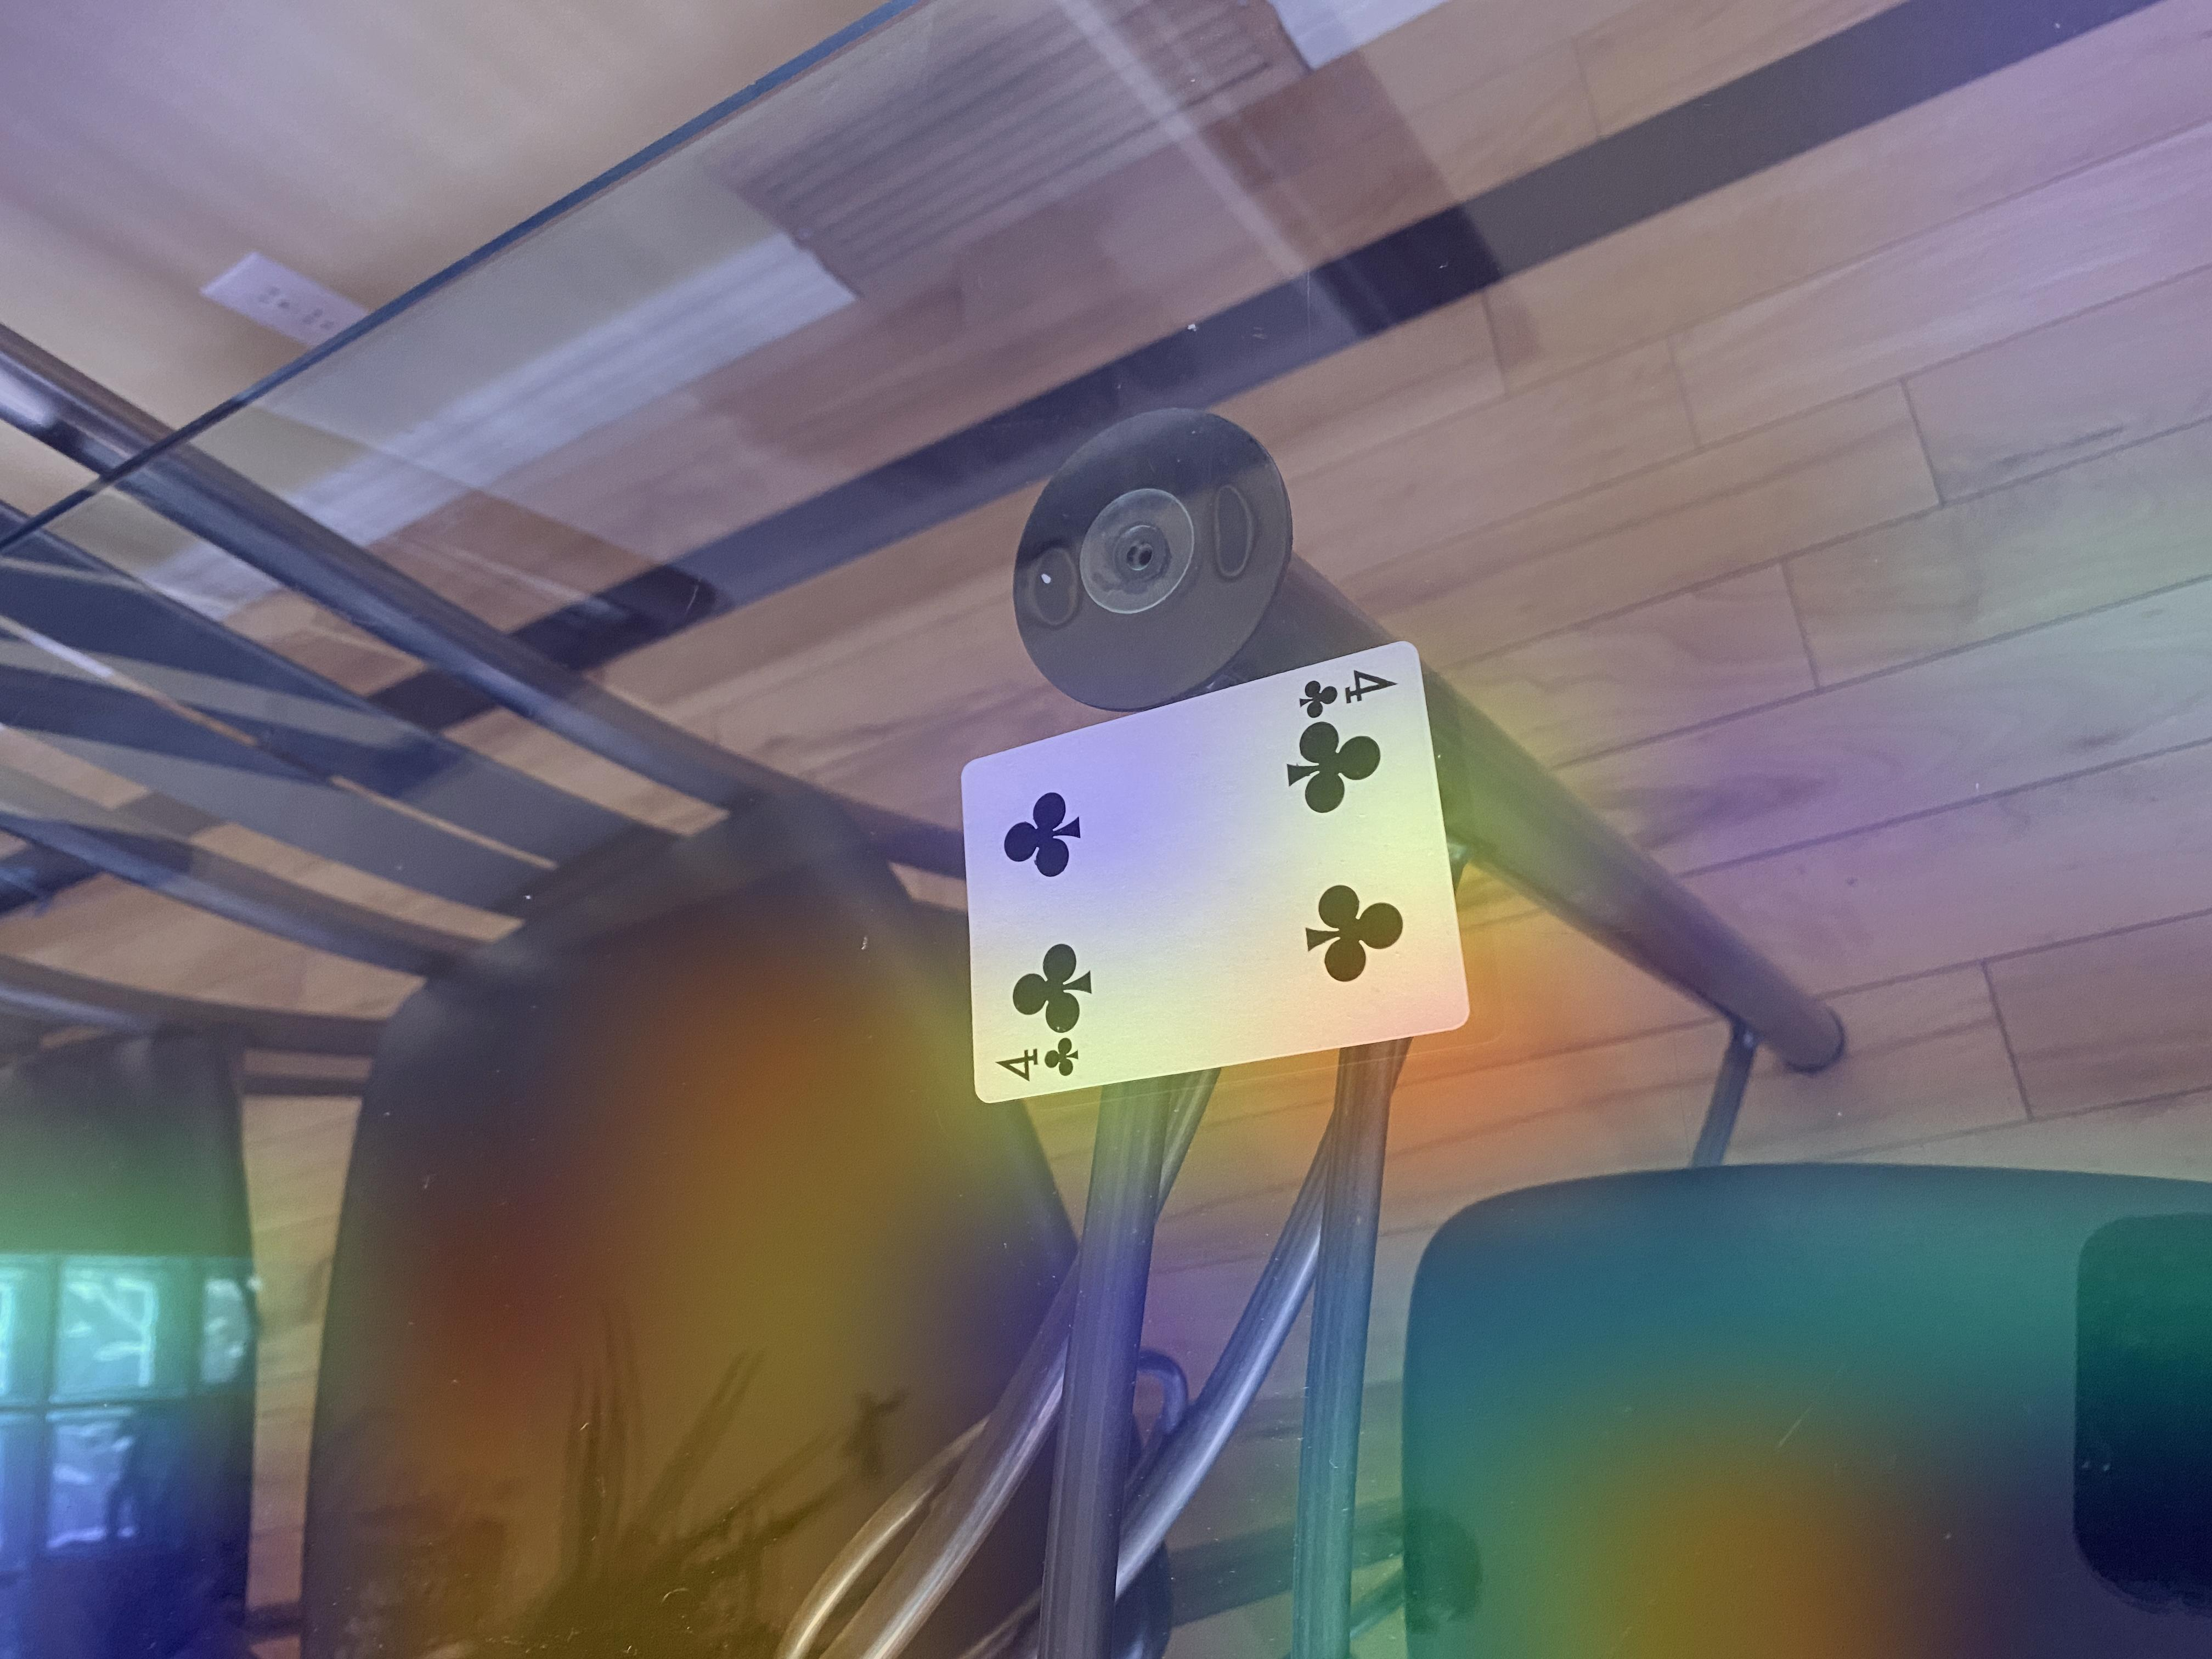

Predicted: ('7_diamonds', 99.8982846736908)


In [21]:
img_path = "dataset_test_hard/4_clubs/IMG_6919.jpg"
img = image.load_img(img_path, target_size=(img_width, img_height))
plt.figure(figsize = (10,10))
plt.imshow(img)
# Code from https://keras.io/examples/vision/grad_cam/

img_array = preprocess_input(get_img_array(img_path, size=(img_height, img_width)))

# Make model
#

# Remove last layer's softmax
#model.layers[-1].activation = None
pred = model.predict(img_array)
print("Predicted:", decode_predictions(pred))


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model.layers[1], last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(img_path, heatmap)